In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'california-housing-prices' dataset.
Path to dataset files: /kaggle/input/california-housing-prices


In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# x, y = fetch_california_housing(return_X_y=True)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

housing_data_path = "/kaggle/input/california-housing-prices/housing.csv"
df = pd.read_csv(housing_data_path)
df = df.dropna() # remove the rows that contains null values
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
X = df.drop("median_house_value", axis=1) #median_house_value is the target variable (what we want to predict) #axis=1 means drop a column axis=0 would drop rows
Y = df["median_house_value"]
X = pd.get_dummies(X, columns=['ocean_proximity'], drop_first=True)  #This avoids the dummy variable trap (multicollinearity).
print("Features after encoding:")
print(X.columns.tolist())
print(f"\nX shape: {X.shape}")  #X.shape → (number_of_rows, number_of_features)

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

Features after encoding:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']

X shape: (20433, 12)


In [7]:
# Scale the features AND target variable
scaler_X = StandardScaler() #for features
scaler_y = StandardScaler() # for target
x_train_scaled = scaler_X.fit_transform(x_train)
x_test_scaled = scaler_X.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel() # StandardScaler expects a 2D array but y_train is a Pandas Series → 1D
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()  # ravel. Converts 2D array back to 1D

In [8]:
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train_scaled)

LinearRegression()

In [9]:
# Make predictions
y_train_pred = linear_model.predict(x_train_scaled) # To check how well the model fit the data it learned from and Used to detect underfitting / overfitting
y_test_pred = linear_model.predict(x_test_scaled)

In [10]:
# Calculate MSE on scaled data
train_mse = mean_squared_error(y_train_scaled, y_train_pred)
test_mse = mean_squared_error(y_test_scaled, y_test_pred)

In [11]:
print(f"\nTraining MSE: {train_mse:.3f}")
print(f"Test MSE:     {test_mse:.3f}")


Training MSE: 0.354
Test MSE:     0.363


In [12]:
# Display coefficients
coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_model.coef_
})

In [13]:
print("\nTop 10 Model Coefficients:")
print(coefficients_df.sort_values('Coefficient', key=abs, ascending=False).head(10))


Top 10 Model Coefficients:
                  Feature  Coefficient
7           median_income     0.647872
1                latitude    -0.476378
0               longitude    -0.472620
4          total_bedrooms     0.373744
5              population    -0.357397
8  ocean_proximity_INLAND    -0.158489
6              households     0.141739
3             total_rooms    -0.118322
2      housing_median_age     0.118209
9  ocean_proximity_ISLAND     0.025155


In [14]:
print(f"\nTraining set size: {x_train_scaled.shape[0]}") #x_train_scaled.shape returns a tuple: (number_of_rows, number_of_features) shape[0] → number of samples (rows)
print(f"Test set size: {x_test_scaled.shape[0]}")

# ============================================
# STEP 2: HYPERPARAMETER TUNING
# ============================================


Training set size: 16346
Test set size: 4087


In [15]:
print("\n" + "="*70) #"\n" → inserts a blank line before the output and  "=" * 70 → repeats the = character 70 times
print("STEP 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV") #Clearly labels the next phase of the workflow → Model optimization
print("="*70) #This creates a boxed header effect:
#Visually separates sections in the output and Makes console output easier to scan


STEP 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV


In [16]:
# Define the grid of alpha values (regularization strength)
# Using a wide range from very small to very large values
# Alpha controls how strongly the model penalizes large coefficients.
alpha_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
}

print("\nAlpha values to test:", alpha_grid['alpha'])


Alpha values to test: [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [17]:
# ============================================
# RIDGE REGRESSION TUNING
# ============================================

print("\n" + "-"*70)
print("RIDGE REGRESSION")
print("-"*70)

# Create Ridge model
ridge = Ridge()

# Perform GridSearchCV with 5-fold cross-validation
ridge_grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=alpha_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nTraining Ridge with GridSearchCV...")
ridge_grid_search.fit(x_train_scaled, y_train_scaled)


----------------------------------------------------------------------
RIDGE REGRESSION
----------------------------------------------------------------------

Training Ridge with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
             scoring='neg_mean_squared_error', verbose=1)

In [18]:
# Get the best parameters
best_ridge_alpha = ridge_grid_search.best_params_['alpha']
print(f"\n✓ Best alpha for Ridge: {best_ridge_alpha}")

# Get cross-validation results
ridge_cv_results = pd.DataFrame(ridge_grid_search.cv_results_)
ridge_cv_results['mean_mse'] = -ridge_cv_results['mean_test_score']
ridge_cv_results['std_mse'] = ridge_cv_results['std_test_score']

print("\nCross-Validation Results for Ridge:")
print(ridge_cv_results[['param_alpha', 'mean_mse', 'std_mse']].to_string(index=False))


✓ Best alpha for Ridge: 10

Cross-Validation Results for Ridge:
 param_alpha  mean_mse  std_mse
       0.001  0.357540 0.029032
       0.010  0.357540 0.029032
       0.100  0.357540 0.029031
       1.000  0.357534 0.029015
      10.000  0.357493 0.028856
     100.000  0.357787 0.027482
    1000.000  0.369099 0.022582
   10000.000  0.476420 0.019969


In [19]:
# Train the best Ridge model
best_ridge_model = Ridge(alpha=best_ridge_alpha)
best_ridge_model.fit(x_train_scaled, y_train_scaled)

# Make predictions
ridge_train_pred = best_ridge_model.predict(x_train_scaled)
ridge_test_pred = best_ridge_model.predict(x_test_scaled)

# Calculate MSE
ridge_train_mse = mean_squared_error(y_train_scaled, ridge_train_pred)
ridge_test_mse = mean_squared_error(y_test_scaled, ridge_test_pred)

print(f"\nRidge Model Performance:")
print(f"Training MSE: {ridge_train_mse:.4f}")
print(f"Test MSE:     {ridge_test_mse:.4f}")


Ridge Model Performance:
Training MSE: 0.3544
Test MSE:     0.3628


In [20]:
# ============================================
# LASSO REGRESSION TUNING
# ============================================

print("\n" + "-"*70)
print("LASSO REGRESSION")
print("-"*70)

# Create Lasso model
lasso = Lasso(max_iter=10000)  # Increased max_iter for convergence

# Perform GridSearchCV with 5-fold cross-validation
lasso_grid_search = GridSearchCV(
    estimator=lasso,
    param_grid=alpha_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nTraining Lasso with GridSearchCV...")
lasso_grid_search.fit(x_train_scaled, y_train_scaled)


----------------------------------------------------------------------
LASSO REGRESSION
----------------------------------------------------------------------

Training Lasso with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(max_iter=10000), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
             scoring='neg_mean_squared_error', verbose=1)

In [21]:
# Get the best parameters
best_lasso_alpha = lasso_grid_search.best_params_['alpha']
print(f"\n✓ Best alpha for Lasso: {best_lasso_alpha}")

# Get cross-validation results
lasso_cv_results = pd.DataFrame(lasso_grid_search.cv_results_)
lasso_cv_results['mean_mse'] = -lasso_cv_results['mean_test_score']
lasso_cv_results['std_mse'] = lasso_cv_results['std_test_score']

print("\nCross-Validation Results for Lasso:")
print(lasso_cv_results[['param_alpha', 'mean_mse', 'std_mse']].to_string(index=False))


✓ Best alpha for Lasso: 0.001

Cross-Validation Results for Lasso:
 param_alpha  mean_mse  std_mse
       0.001  0.357523 0.028480
       0.010  0.364981 0.024084
       0.100  0.431730 0.021229
       1.000  1.000163 0.036360
      10.000  1.000163 0.036360
     100.000  1.000163 0.036360
    1000.000  1.000163 0.036360
   10000.000  1.000163 0.036360


In [22]:
# Train the best Lasso model
best_lasso_model = Lasso(alpha=best_lasso_alpha, max_iter=10000)
best_lasso_model.fit(x_train_scaled, y_train_scaled)

# Make predictions
lasso_train_pred = best_lasso_model.predict(x_train_scaled)
lasso_test_pred = best_lasso_model.predict(x_test_scaled)

# Calculate MSE
lasso_train_mse = mean_squared_error(y_train_scaled, lasso_train_pred)
lasso_test_mse = mean_squared_error(y_test_scaled, lasso_test_pred)

print(f"\nLasso Model Performance:")
print(f"Training MSE: {lasso_train_mse:.4f}")
print(f"Test MSE:     {lasso_test_mse:.4f}")

# Count non-zero coefficients (feature selection by Lasso)
non_zero_coefs = np.sum(best_lasso_model.coef_ != 0)
print(f"Number of non-zero coefficients: {non_zero_coefs} out of {len(best_lasso_model.coef_)}")


Lasso Model Performance:
Training MSE: 0.3545
Test MSE:     0.3629
Number of non-zero coefficients: 12 out of 12


In [23]:
# SUMMARY
# ============================================

print("\n" + "="*70)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*70)

summary_data = {
    'Model': ['Ridge', 'Lasso'],
    'Best Alpha': [best_ridge_alpha, best_lasso_alpha],
    'Training MSE': [f"{ridge_train_mse:.4f}", f"{lasso_train_mse:.4f}"],
    'Test MSE': [f"{ridge_test_mse:.4f}", f"{lasso_test_mse:.4f}"],
    'Non-zero Coefs': [len(best_ridge_model.coef_), non_zero_coefs]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n" + "="*70)
print("Key Insights:")
print("-"*70)
print(f"• Ridge selected alpha = {best_ridge_alpha}, keeping all features")
print(f"• Lasso selected alpha = {best_lasso_alpha}, keeping {non_zero_coefs}/{len(best_lasso_model.coef_)} features")
print(f"• Lasso performs feature selection by setting {len(best_lasso_model.coef_) - non_zero_coefs} coefficients to zero")

if ridge_test_mse < lasso_test_mse:
    print(f"• Ridge has lower test MSE ({ridge_test_mse:.4f} vs {lasso_test_mse:.4f})")
else:
    print(f"• Lasso has lower test MSE ({lasso_test_mse:.4f} vs {ridge_test_mse:.4f})")

print("="*70)


HYPERPARAMETER TUNING SUMMARY

 Model  Best Alpha Training MSE Test MSE  Non-zero Coefs
Ridge      10.000       0.3544   0.3628              12
Lasso       0.001       0.3545   0.3629              12

Key Insights:
----------------------------------------------------------------------
• Ridge selected alpha = 10, keeping all features
• Lasso selected alpha = 0.001, keeping 12/12 features
• Lasso performs feature selection by setting 0 coefficients to zero
• Ridge has lower test MSE (0.3628 vs 0.3629)


In [24]:
# Scale features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_X.fit_transform(x_train)
x_test_scaled = scaler_X.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

feature_names = X.columns.tolist()

print("="*80)
print("STEP 3: REGULARIZATION EXPERIMENTS (L1 vs L2)")
print("="*80)

STEP 3: REGULARIZATION EXPERIMENTS (L1 vs L2)


In [25]:
# ============================================
# PART 1: TRAIN MODELS WITH OPTIMAL ALPHAS
# ============================================

print("\n" + "-"*80)
print("PART 1: TRAINING MODELS WITH OPTIMAL HYPERPARAMETERS")
print("-"*80)

# Use optimal alphas (you can adjust these based on your Step 2 results)
# These are typical good values, but replace with your actual best alphas
optimal_ridge_alpha = 10  # Replace with your best alpha from Step 2
optimal_lasso_alpha = 0.01  # Replace with your best alpha from Step 2

print(f"\nUsing optimal alphas:")
print(f"  Ridge (L2): α = {optimal_ridge_alpha}")
print(f"  Lasso (L1): α = {optimal_lasso_alpha}")


--------------------------------------------------------------------------------
PART 1: TRAINING MODELS WITH OPTIMAL HYPERPARAMETERS
--------------------------------------------------------------------------------

Using optimal alphas:
  Ridge (L2): α = 10
  Lasso (L1): α = 0.01


In [26]:
# Train baseline model (no regularization)
baseline_model = LinearRegression()
baseline_model.fit(x_train_scaled, y_train_scaled)

# Train Ridge model (L2 regularization)
ridge_model = Ridge(alpha=optimal_ridge_alpha)
ridge_model.fit(x_train_scaled, y_train_scaled)

# Train Lasso model (L1 regularization)
lasso_model = Lasso(alpha=optimal_lasso_alpha, max_iter=10000)
lasso_model.fit(x_train_scaled, y_train_scaled)

print("\n✓ All models trained successfully!")


✓ All models trained successfully!


In [27]:
# ============================================
# PART 2: COEFFICIENT COMPARISON
# ============================================

print("\n" + "-"*80)
print("PART 2: COEFFICIENT ANALYSIS")
print("-"*80)

# Create coefficient comparison dataframe
coef_comparison = pd.DataFrame({
    'Feature': feature_names,
    'Baseline': baseline_model.coef_,
    'Ridge (L2)': ridge_model.coef_,
    'Lasso (L1)': lasso_model.coef_
})

# Count zero coefficients
baseline_zeros = np.sum(np.abs(baseline_model.coef_) < 1e-10)
ridge_zeros = np.sum(np.abs(ridge_model.coef_) < 1e-10)
lasso_zeros = np.sum(lasso_model.coef_ == 0)

print(f"\nCoefficient Statistics:")
print(f"  Total features: {len(feature_names)}")
print(f"  Baseline - Zero coefficients: {baseline_zeros}")
print(f"  Ridge (L2) - Zero coefficients: {ridge_zeros}")
print(f"  Lasso (L1) - Zero coefficients: {lasso_zeros}")
print(f"\n  → Lasso eliminated {lasso_zeros} features (sparse solution)")
print(f"  → Ridge kept all {len(feature_names)} features (dense solution)")

# Show top features by absolute coefficient value
print("\n" + "="*80)
print("TOP 10 FEATURES BY ABSOLUTE COEFFICIENT VALUE")
print("="*80)

for model_name in ['Baseline', 'Ridge (L2)', 'Lasso (L1)']:
    print(f"\n{model_name}:")
    # Create absolute value column for sorting
    coef_comparison['abs_coef'] = coef_comparison[model_name].abs()
    top_features = coef_comparison.nlargest(10, 'abs_coef')
    print(top_features[['Feature', model_name]].to_string(index=False))



--------------------------------------------------------------------------------
PART 2: COEFFICIENT ANALYSIS
--------------------------------------------------------------------------------

Coefficient Statistics:
  Total features: 12
  Baseline - Zero coefficients: 0
  Ridge (L2) - Zero coefficients: 0
  Lasso (L1) - Zero coefficients: 2

  → Lasso eliminated 2 features (sparse solution)
  → Ridge kept all 12 features (dense solution)

TOP 10 FEATURES BY ABSOLUTE COEFFICIENT VALUE

Baseline:
               Feature  Baseline
         median_income  0.647872
              latitude -0.476378
             longitude -0.472620
        total_bedrooms  0.373744
            population -0.357397
ocean_proximity_INLAND -0.158489
            households  0.141739
           total_rooms -0.118322
    housing_median_age  0.118209
ocean_proximity_ISLAND  0.025155

Ridge (L2):
               Feature  Ridge (L2)
         median_income    0.647006
              latitude   -0.466173
             longi

In [28]:
# ============================================
# PART 3: MODEL PERFORMANCE COMPARISON
# ============================================

print("\n" + "-"*80)
print("PART 3: MODEL PERFORMANCE EVALUATION")
print("-"*80)

# Calculate predictions and MSE for all models
models = {
    'Baseline': baseline_model,
    'Ridge (L2)': ridge_model,
    'Lasso (L1)': lasso_model
}

results = []

for name, model in models.items():
    train_pred = model.predict(x_train_scaled)
    test_pred = model.predict(x_test_scaled)

    train_mse = mean_squared_error(y_train_scaled, train_pred)
    test_mse = mean_squared_error(y_test_scaled, test_pred)

    # Calculate difference (overfitting measure)
    overfit_gap = test_mse - train_mse
    overfit_pct = (overfit_gap / train_mse) * 100

    results.append({
        'Model': name,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Gap': overfit_gap,
        'Gap %': overfit_pct
    })

results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))


--------------------------------------------------------------------------------
PART 3: MODEL PERFORMANCE EVALUATION
--------------------------------------------------------------------------------

Model Performance Comparison:
     Model  Train MSE  Test MSE      Gap    Gap %
  Baseline   0.354352  0.362787 0.008436 2.380601
Ridge (L2)   0.354359  0.362798 0.008439 2.381501
Lasso (L1)   0.362951  0.372429 0.009478 2.611396


In [29]:
# ============================================
# PART 4: BIAS-VARIANCE TRADEOFF ANALYSIS
# ============================================

print("\n" + "-"*80)
print("PART 4: BIAS-VARIANCE TRADEOFF ANALYSIS")
print("-"*80)

print("\nKey Observations:")

# Analyze each model
for idx, row in results_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Training MSE: {row['Train MSE']:.4f}")
    print(f"  Test MSE:     {row['Test MSE']:.4f}")
    print(f"  Gap:          {row['Gap']:.4f} ({row['Gap %']:.2f}%)")

    if row['Gap %'] > 5:
        print(f"  → Shows signs of overfitting (high variance)")
    elif row['Gap %'] < -5:
        print(f"  → Shows signs of underfitting (high bias)")
    else:
        print(f"  → Well-balanced bias-variance tradeoff")

print("\n" + "="*80)
print("REGULARIZATION EFFECTS:")
print("="*80)
print("""
L1 (Lasso) Regularization:
  • Produces SPARSE solutions (sets some coefficients to zero)
  • Performs automatic feature selection
  • Reduces variance by eliminating irrelevant features
  • Useful when you suspect many features are irrelevant

L2 (Ridge) Regularization:
  • Produces DENSE solutions (shrinks all coefficients)
  • Keeps all features but reduces their magnitude
  • Reduces variance by penalizing large coefficients
  • Useful when all features may contribute to prediction

Bias-Variance Tradeoff:
  • Too little regularization (small α) → High variance, overfitting
  • Optimal regularization → Balanced bias and variance
  • Too much regularization (large α) → High bias, underfitting
""")


--------------------------------------------------------------------------------
PART 4: BIAS-VARIANCE TRADEOFF ANALYSIS
--------------------------------------------------------------------------------

Key Observations:

Baseline:
  Training MSE: 0.3544
  Test MSE:     0.3628
  Gap:          0.0084 (2.38%)
  → Well-balanced bias-variance tradeoff

Ridge (L2):
  Training MSE: 0.3544
  Test MSE:     0.3628
  Gap:          0.0084 (2.38%)
  → Well-balanced bias-variance tradeoff

Lasso (L1):
  Training MSE: 0.3630
  Test MSE:     0.3724
  Gap:          0.0095 (2.61%)
  → Well-balanced bias-variance tradeoff

REGULARIZATION EFFECTS:

L1 (Lasso) Regularization:
  • Produces SPARSE solutions (sets some coefficients to zero)
  • Performs automatic feature selection
  • Reduces variance by eliminating irrelevant features
  • Useful when you suspect many features are irrelevant

L2 (Ridge) Regularization:
  • Produces DENSE solutions (shrinks all coefficients)
  • Keeps all features but reduce

In [31]:
# Part 2: Classification Task (Breast Cancer)
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

baseline_model = LogisticRegression(max_iter=10000, solver='liblinear')
baseline_model.fit(X_train, y_train)


print("Model coefficients:\n", baseline_model.coef_)

y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Model coefficients:
 [[ 2.13248406e+00  1.52771940e-01 -1.45091255e-01 -8.28669349e-04
  -1.42636015e-01 -4.15568847e-01 -6.51940282e-01 -3.44456106e-01
  -2.07613380e-01 -2.97739324e-02 -5.00338038e-02  1.44298427e+00
  -3.03857384e-01 -7.25692126e-02 -1.61591524e-02 -1.90655332e-03
  -4.48855442e-02 -3.77188737e-02 -4.17516190e-02  5.61347410e-03
   1.23214996e+00 -4.04581097e-01 -3.62091502e-02 -2.70867580e-02
  -2.62630530e-01 -1.20898539e+00 -1.61796947e+00 -6.15250835e-01
  -7.42763610e-01 -1.16960181e-01]]
Training Accuracy: 0.9582
Test Accuracy: 0.9561


In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}


grid_search = GridSearchCV(LogisticRegression(max_iter=10000),
                           param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

train_acc_best = accuracy_score(y_train, best_model.predict(X_train))
test_acc_best = accuracy_score(y_test, best_model.predict(X_test))
print(f"Training Accuracy (best): {train_acc_best:.4f}")
print(f"Test Accuracy (best): {test_acc_best:.4f}")

Best hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Training Accuracy (best): 0.9890
Test Accuracy (best): 0.9825


In [34]:
C_best = grid_search.best_params_['C']


model_l1 = LogisticRegression(C=C_best, penalty='l1', solver='liblinear', max_iter=10000)
model_l1.fit(X_train, y_train)


model_l2 = LogisticRegression(C=C_best, penalty='l2', solver='liblinear', max_iter=10000)
model_l2.fit(X_train, y_train)


print("L1 Coefficients:\n", model_l1.coef_)
print("L2 Coefficients:\n", model_l2.coef_)

print("L1 Train Accuracy:", accuracy_score(y_train, model_l1.predict(X_train)))
print("L1 Test Accuracy:", accuracy_score(y_test, model_l1.predict(X_test)))
print("L2 Train Accuracy:", accuracy_score(y_train, model_l2.predict(X_train)))
print("L2 Test Accuracy:", accuracy_score(y_test, model_l2.predict(X_test)))

L1 Coefficients:
 [[ 7.17808365e-01 -1.07207232e-01  9.57737616e-02 -1.86016853e-03
   0.00000000e+00  4.74323419e+01 -1.15230002e+01 -1.36289604e+02
   1.99150968e+01  0.00000000e+00  0.00000000e+00  1.72453974e+00
   0.00000000e+00 -1.97563228e-01  0.00000000e+00  0.00000000e+00
   4.97797742e+01  0.00000000e+00  1.84816242e+01  0.00000000e+00
   2.07477482e-01 -4.38535906e-01  5.43909379e-02 -2.07819123e-02
  -2.17398214e+01  8.01248679e+00 -1.46961613e+01 -2.51580016e+01
  -2.53277582e+01  0.00000000e+00]]
L2 Coefficients:
 [[ 5.40272741  0.26573732 -0.52651203 -0.02095479 -2.29922151 -0.2169419
  -3.56980218 -5.0110607  -2.26418385  0.36762747 -0.58036525  3.84169255
  -0.63875637 -0.10714305 -0.40591246  3.57237002  4.36577514 -0.26636925
   0.39354765  0.62630698 -0.20718582 -0.68999884  0.17661962 -0.01813087
  -4.67716843 -0.0140846  -4.46493229 -7.61271125 -6.83571871  0.57463274]]
L1 Train Accuracy: 0.989010989010989
L1 Test Accuracy: 0.9824561403508771
L2 Train Accuracy: 0.

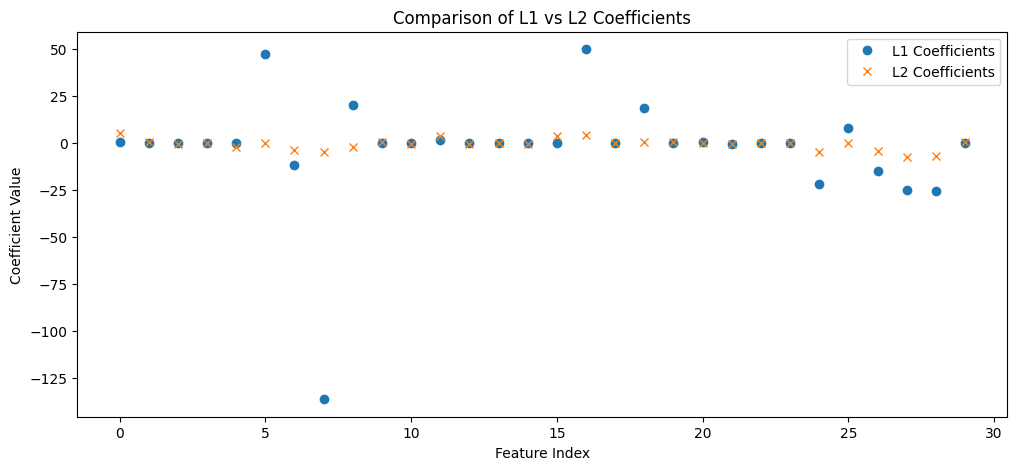

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(model_l1.coef_.flatten(), 'o', label='L1 Coefficients')
plt.plot(model_l2.coef_.flatten(), 'x', label='L2 Coefficients')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Comparison of L1 vs L2 Coefficients')
plt.legend()
plt.show()